In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [3]:
class CNN_Block(keras.layers.Layer):
    def __init__(self, out_channel, kernel_size=3, padding='same'):
        super(CNN_Block, self).__init__()
        self.conv= keras.layers.Conv2D(out_channel, kernel_size= kernel_size, padding= padding)
        self.bn= keras.layers.BatchNormalization()

    def call(self, input_tensor, training= False):
        x= self.conv(input_tensor)
        x= self.bn(x, training=training)
        x= tf.nn.relu(x)

        return x

In [4]:
model= keras.Sequential([
    keras.layers.Input(x_test[0].shape),
    CNN_Block(32), CNN_Block(32), CNN_Block(64),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [5]:
cnn_history= model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 16s 13ms/step - loss: 1.8933 - accuracy: 0.4954 - val_loss: 1.4219 - val_accuracy: 0.5301
Epoch 2/5
782/782 [==============================] - 8s 11ms/step - loss: 0.9563 - accuracy: 0.6655 - val_loss: 1.1721 - val_accuracy: 0.6131
Epoch 3/5
782/782 [==============================] - 8s 11ms/step - loss: 0.7804 - accuracy: 0.7276 - val_loss: 1.1095 - val_accuracy: 0.6198
Epoch 4/5
782/782 [==============================] - 9s 12ms/step - loss: 0.6349 - accuracy: 0.7809 - val_loss: 1.2608 - val_accuracy: 0.5950
Epoch 5/5
782/782 [==============================] - 9s 11ms/step - loss: 0.4950 - accuracy: 0.8275 - val_loss: 1.2011 - val_accuracy: 0.6203


In [6]:
class ResBlock_Layers(keras.layers.Layer):
    def __init__(self, channel_list=[16, 16, 32]):
        super(ResBlock_Layers, self).__init__()

        self.conv1= CNN_Block(channel_list[0], kernel_size=3, padding='same')
        self.conv2= CNN_Block(channel_list[1], kernel_size=3, padding='same')
        self.conv3= CNN_Block(channel_list[2], kernel_size=3, padding='same')
        self.pooling= keras.layers.MaxPool2D()
        self.identity_mapping= keras.layers.Conv2D(channel_list[0], kernel_size=1, padding='same')

    def call(self, input_tensor, training= False):
        x= self.conv1(input_tensor, training=training)
        x= self.conv2(x, training=training)
        x= self.conv3(x+self.identity_mapping(input_tensor), training=training)
        x= self.pooling(x)

        return x

In [7]:
class ResNet(keras.Model):
    def __init__(self, num_output=10):
        super(ResNet, self).__init__()

        self.block1= ResBlock_Layers([32, 32, 64])
        self.block2= ResBlock_Layers([128, 128, 256])
        self.block3= ResBlock_Layers([128, 128, 256])
        self.pooling= keras.layers.GlobalAveragePooling2D()
        # self.dense1= keras.layers.Dense(32, 'relu')
        self.classifier= keras.layers.Dense(num_output)

    def call(self, input_tensor, training=False):
        x= self.block1(input_tensor, training=training)
        x= self.block2(x, training=training)
        x= self.block3(x, training=training)
        x= self.pooling(x, training=training)
        # x= self.dense1(x, training=training)
        x= self.classifier(x)

        return x

    # def model(self):
    #     input= keras.Input(shape=(28,28,1))
    #     output= self.call(input)

    #     return keras.Model(inputs=[input], outputs=output)

In [8]:
model= ResNet(10)

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.build([1]+list(x_train[0].shape))
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block__layers (ResBlock  multiple                 29280     
 _Layers)                                                        
                                                                 
 res_block__layers_1 (ResBlo  multiple                 526976    
 ck_Layers)                                                      
                                                                 
 res_block__layers_2 (ResBlo  multiple                 772736    
 ck_Layers)                                                      
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             multiple                  2570

In [9]:
resnet_history= model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 26s 29ms/step - loss: 1.1115 - accuracy: 0.6032 - val_loss: 1.7251 - val_accuracy: 0.4932
Epoch 2/5
782/782 [==============================] - 21s 26ms/step - loss: 0.6813 - accuracy: 0.7596 - val_loss: 2.4896 - val_accuracy: 0.4225
Epoch 3/5
782/782 [==============================] - 20s 25ms/step - loss: 0.5221 - accuracy: 0.8184 - val_loss: 1.4427 - val_accuracy: 0.5676
Epoch 4/5
782/782 [==============================] - 21s 27ms/step - loss: 0.4148 - accuracy: 0.8560 - val_loss: 0.8549 - val_accuracy: 0.7260
Epoch 5/5
782/782 [==============================] - 21s 27ms/step - loss: 0.3313 - accuracy: 0.8861 - val_loss: 0.6910 - val_accuracy: 0.7759


In [10]:
cnn_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
cnn_history= cnn_history.history
resnet_history= resnet_history.history

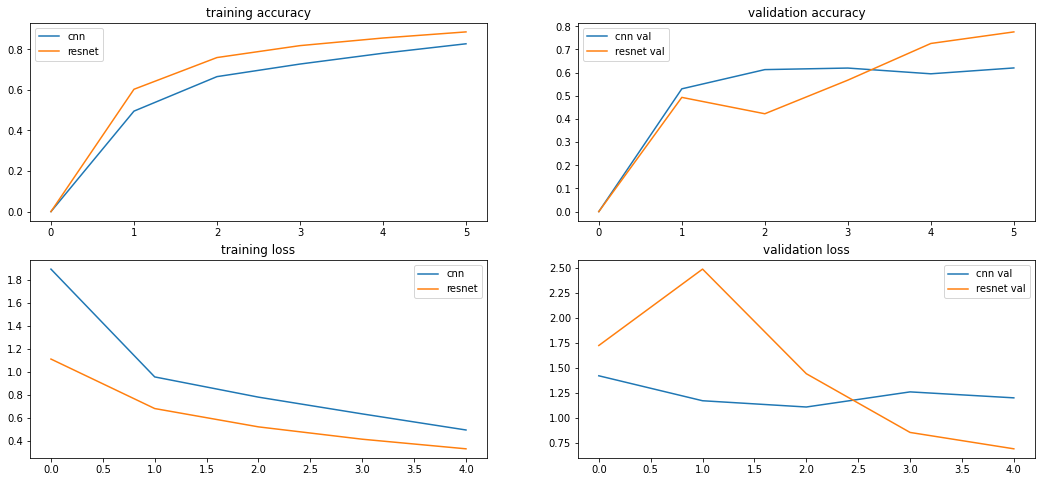

In [30]:
from matplotlib import pyplot as plt

fig= plt.figure(figsize=(18,8))

ax1= fig.add_subplot(221)
ax2= fig.add_subplot(222)
ax3= fig.add_subplot(223)
ax4= fig.add_subplot(224)

ax1.plot([0]+cnn_history['accuracy'], label='cnn')
ax1.plot([0]+resnet_history['accuracy'], label='resnet')
ax1.set_title('training accuracy')
ax1.legend()

ax2.plot([0]+cnn_history['val_accuracy'], label='cnn val')
ax2.plot([0]+resnet_history['val_accuracy'], label='resnet val')
ax2.set_title('validation accuracy')
ax2.legend()

ax3.plot(cnn_history['loss'], label='cnn')
ax3.plot(resnet_history['loss'], label='resnet')
ax3.set_title('training loss')
ax3.legend()

ax4.plot(cnn_history['val_loss'], label='cnn val')
ax4.plot(resnet_history['val_loss'], label='resnet val')
ax4.set_title('validation loss')
ax4.legend()

plt.show()